In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import numpy as np
import sys
sys.path.append("./../code/")
from population_model import massModel,truncatedNormal
from tqdm import tqdm

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [2]:
nn_data = az.from_netcdf("../data/output_dynamicInjections.cdf")
inj_data = az.from_netcdf("../data/output_standardInjections.cdf")

In [3]:
nn_samps = nn_data.posterior.stack(draws=("chain", "draw"))
inj_samps = inj_data.posterior.stack(draws=("chain", "draw"))

In [4]:
nDraws = 3000

In [5]:
m_grid = np.linspace(2,100,500)
z_grid = np.linspace(0,1.5,500)
R_zs_nn = np.zeros((nDraws,z_grid.size))
R_zs_inj = np.zeros((nDraws,z_grid.size))
R_zs_m_ref_nn = np.zeros((nDraws,z_grid.size))
R_zs_m_ref_inj = np.zeros((nDraws,z_grid.size))

for i in range(nDraws):
    
    p_m_nn = massModel(m_grid,
                    nn_samps.alpha.values[i],
                    nn_samps.mu_m1.values[i],
                    nn_samps.sig_m1.values[i],
                    10.**nn_samps.log_f_peak.values[i],
                    nn_samps.mMax.values[i],
                    nn_samps.mMin.values[i],
                    10.**nn_samps.log_dmMax.values[i],
                    10.**nn_samps.log_dmMin.values[i])
    
    p_m_ref_nn = massModel(20.,
                    nn_samps.alpha.values[i],
                    nn_samps.mu_m1.values[i],
                    nn_samps.sig_m1.values[i],
                    10.**nn_samps.log_f_peak.values[i],
                    nn_samps.mMax.values[i],
                    nn_samps.mMin.values[i],
                    10.**nn_samps.log_dmMax.values[i],
                    10.**nn_samps.log_dmMin.values[i])
    
    p_m_inj = massModel(m_grid,
                    inj_samps.alpha.values[i],
                    inj_samps.mu_m1.values[i],
                    inj_samps.sig_m1.values[i],
                    10.**inj_samps.log_f_peak.values[i],
                    inj_samps.mMax.values[i],
                    inj_samps.mMin.values[i],
                    10.**inj_samps.log_dmMax.values[i],
                    10.**inj_samps.log_dmMin.values[i])
    
    p_m_ref_inj = massModel(20.,
                    inj_samps.alpha.values[i],
                    inj_samps.mu_m1.values[i],
                    inj_samps.sig_m1.values[i],
                    10.**inj_samps.log_f_peak.values[i],
                    inj_samps.mMax.values[i],
                    inj_samps.mMin.values[i],
                    10.**inj_samps.log_dmMax.values[i],
                    10.**inj_samps.log_dmMin.values[i])
    
    R_zs_nn[i,:] = nn_samps.R20.values[i]*np.trapz(p_m_nn/p_m_ref_nn,m_grid)*((1.+z_grid)/(1.+0.2))**nn_samps.kappa.values[i]
    R_zs_inj[i,:] = inj_samps.R20.values[i]*np.trapz(p_m_inj/p_m_ref_inj,m_grid)*((1.+z_grid)/(1.+0.2))**inj_samps.kappa.values[i]

In [6]:
m_grid = np.linspace(2,100,500)
q_grid = np.linspace(0,1,499)

M,Q = np.meshgrid(m_grid,q_grid)

p_ms_nn = np.zeros((nDraws,m_grid.size))
p_ms_inj = np.zeros((nDraws,m_grid.size))
p_qs_nn = np.zeros((nDraws,q_grid.size))
p_qs_inj = np.zeros((nDraws,q_grid.size))

for i in tqdm(range(nDraws)):
    
    p_m_nn = massModel(M,
                    nn_samps.alpha.values[i],
                    nn_samps.mu_m1.values[i],
                    nn_samps.sig_m1.values[i],
                    10.**nn_samps.log_f_peak.values[i],
                    nn_samps.mMax.values[i],
                    nn_samps.mMin.values[i],
                    10.**nn_samps.log_dmMax.values[i],
                    10.**nn_samps.log_dmMin.values[i])
    
    p_m_inj = massModel(M,
                    inj_samps.alpha.values[i],
                    inj_samps.mu_m1.values[i],
                    inj_samps.sig_m1.values[i],
                    10.**inj_samps.log_f_peak.values[i],
                    inj_samps.mMax.values[i],
                    inj_samps.mMin.values[i],
                    10.**inj_samps.log_dmMax.values[i],
                    10.**inj_samps.log_dmMin.values[i])
    
    # Construct 2D NN distribution
    bq_nn = nn_samps.bq.values[i]
    p_q_nn = (1.+bq_nn)*Q**bq_nn/(1.-(2./M)**(1.+bq_nn))
    p_q_nn[Q<=2/M] = 0
    p_2D_nn = p_m_nn*p_q_nn
    
    # Marginalize
    p_m_nn = np.sum(p_2D_nn,axis=0)
    p_ms_nn[i,:] = p_m_nn/np.trapz(p_m_nn,m_grid)
    p_q_nn = np.sum(p_2D_nn,axis=1)
    p_qs_nn[i,:] = p_q_nn/np.trapz(p_q_nn,q_grid)
    
    # Construct 2D Inj distribution
    bq_inj = inj_samps.bq.values[i]
    p_q_inj = (1.+bq_inj)*Q**bq_inj/(1.-(2./M)**(1.+bq_inj))
    p_q_inj[Q<=2/M] = 0
    p_2D_inj = p_m_inj*p_q_inj
    
    # Marginalize
    p_m_inj = np.sum(p_2D_inj,axis=0)
    p_ms_inj[i,:] = p_m_inj/np.trapz(p_m_inj,m_grid)
    p_q_inj = np.sum(p_2D_inj,axis=1)
    p_qs_inj[i,:] = p_q_inj/np.trapz(p_q_inj,q_grid)

  0%|                                                                                                                                                                | 0/3000 [00:00<?, ?it/s]/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12092/1611980201.py:35: RuntimeWarning: divide by zero encountered in divide
  p_q_nn = (1.+bq_nn)*Q**bq_nn/(1.-(2./M)**(1.+bq_nn))
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12092/1611980201.py:35: RuntimeWarning: invalid value encountered in divide
  p_q_nn = (1.+bq_nn)*Q**bq_nn/(1.-(2./M)**(1.+bq_nn))
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12092/1611980201.py:47: RuntimeWarning: divide by zero encountered in divide
  p_q_inj = (1.+bq_inj)*Q**bq_inj/(1.-(2./M)**(1.+bq_inj))
/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_12092/1611980201.py:47: RuntimeWarning: invalid value encountered in divide
  p_q_inj = (1.+bq_inj)*Q**bq_inj/(1.-(2./M)**(1.+bq_inj))
  1%|█                                  

In [7]:
chi_grid = np.linspace(0,1,500)
p_chis_nn = np.zeros((nDraws,chi_grid.size))
p_chis_inj = np.zeros((nDraws,chi_grid.size))

for i in range(nDraws):
    
    p_chi_nn = truncatedNormal(chi_grid,
                    nn_samps.mu_chi.values[i],
                    10.**nn_samps.logsig_chi.values[i],
                    0,1)
        
    p_chi_inj = truncatedNormal(chi_grid,
                    inj_samps.mu_chi.values[i],
                    10.**inj_samps.logsig_chi.values[i],
                    0,1)
    
    p_chis_nn[i,:] = p_chi_nn/np.trapz(p_chi_nn,chi_grid)
    p_chis_inj[i,:] = p_chi_inj/np.trapz(p_chi_inj,chi_grid)

In [8]:
cost_grid = np.linspace(-1,1,500)
p_costs_nn = np.zeros((nDraws,cost_grid.size))
p_costs_inj = np.zeros((nDraws,cost_grid.size))

for i in range(nDraws):
    
    f_iso_nn = nn_samps.f_iso.values[i]
    p_cost_nn = f_iso_nn*(1./2.) \
        + (1.-f_iso_nn)*truncatedNormal(cost_grid, nn_samps.mu_cost.values[i], nn_samps.sig_cost.values[i], -1, 1)
      
    f_iso_inj = inj_samps.f_iso.values[i]
    p_cost_inj = f_iso_inj*(1./2.) \
        + (1.-f_iso_inj)*truncatedNormal(cost_grid, inj_samps.mu_cost.values[i], inj_samps.sig_cost.values[i], -1, 1)
    
    p_costs_nn[i,:] = p_cost_nn/np.trapz(p_cost_nn,cost_grid)
    p_costs_inj[i,:] = p_cost_inj/np.trapz(p_cost_inj,cost_grid)

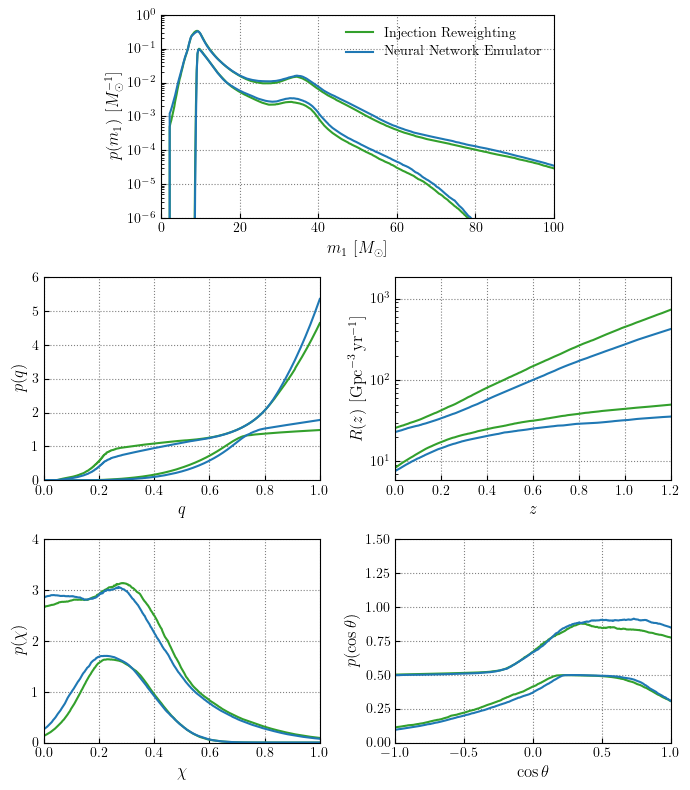

In [9]:
fig = plt.figure(figsize=(7.,8))

## Primary mass
ax = plt.subplot2grid(shape=(3, 6), loc=(0, 1), colspan=4)

ax.plot(m_grid,np.quantile(p_ms_inj,0.05,axis=0),color=cnsbh,lw=1.5,label='Injection Reweighting')
ax.plot(m_grid,np.quantile(p_ms_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(m_grid,np.quantile(p_ms_nn,0.05,axis=0),color=cbbh,lw=1.5,label='Neural Network Emulator')
ax.plot(m_grid,np.quantile(p_ms_nn,0.95,axis=0),color=cbbh,lw=1.5)
ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(1e-6,1)
ax.set_xlabel('$m_1$ $[M_\odot]$')
ax.set_ylabel('$p(m_1)$ $[M_\odot^{-1}]$')
ax.legend(loc='upper right')

## Mass ratio
ax = plt.subplot2grid(shape=(3, 6), loc=(1, 0), colspan=3)

ax.plot(q_grid,np.quantile(p_qs_inj,0.05,axis=0),color=cnsbh,lw=1.5)
ax.plot(q_grid,np.quantile(p_qs_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(q_grid,np.quantile(p_qs_nn,0.05,axis=0),color=cbbh,lw=1.5)
ax.plot(q_grid,np.quantile(p_qs_nn,0.95,axis=0),color=cbbh,lw=1.5)
#ax.set_yscale('log')
ax.set_xlim(0,1)
ax.set_ylim(0,6)
ax.set_xlabel('$q$')
ax.set_ylabel('$p(q)$')

## Redshift
ax = plt.subplot2grid(shape=(3, 6), loc=(1, 3), colspan=3)

ax.plot(z_grid,np.quantile(R_zs_inj,0.05,axis=0),color=cnsbh,lw=1.5)
ax.plot(z_grid,np.quantile(R_zs_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(z_grid,np.quantile(R_zs_nn,0.05,axis=0),color=cbbh,lw=1.5)
ax.plot(z_grid,np.quantile(R_zs_nn,0.95,axis=0),color=cbbh,lw=1.5)
ax.set_yscale('log')
ax.set_xlim(0,1.2)
ax.set_xlabel('$z$')
ax.set_ylabel('$R(z)$ $[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]$')

## Spin magnitude
ax = plt.subplot2grid(shape=(3, 6), loc=(2, 0), colspan=3)

ax.plot(chi_grid,np.quantile(p_chis_inj,0.05,axis=0),color=cnsbh,lw=1.5)
ax.plot(chi_grid,np.quantile(p_chis_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(chi_grid,np.quantile(p_chis_nn,0.05,axis=0),color=cbbh,lw=1.5)
ax.plot(chi_grid,np.quantile(p_chis_nn,0.95,axis=0),color=cbbh,lw=1.5)
ax.set_xlabel('$\chi$')
ax.set_ylabel('$p(\chi)$')
ax.set_xlim(0,1)
ax.set_ylim(0,4)

## Spin tilt
ax = plt.subplot2grid(shape=(3, 6), loc=(2, 3), colspan=3)

ax.plot(cost_grid,np.quantile(p_costs_inj,0.05,axis=0),color=cnsbh,lw=1.5)
ax.plot(cost_grid,np.quantile(p_costs_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(cost_grid,np.quantile(p_costs_nn,0.05,axis=0),color=cbbh,lw=1.5)
ax.plot(cost_grid,np.quantile(p_costs_nn,0.95,axis=0),color=cbbh,lw=1.5)
ax.set_xlabel('$\cos\\theta$')
ax.set_ylabel('$p(\cos\\theta)$')
ax.set_xlim(-1,1)
ax.set_ylim(0,1.5)

plt.tight_layout()
#plt.savefig('figure_08.pdf',bbox_inches='tight')
plt.show()

In [18]:
dm = np.diff(m_grid)[0]
cdf_ms_inj = np.cumsum(p_ms_inj,axis=1)*dm
cdf_ms_nn = np.cumsum(p_ms_nn,axis=1)*dm

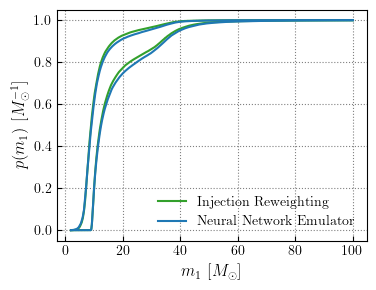

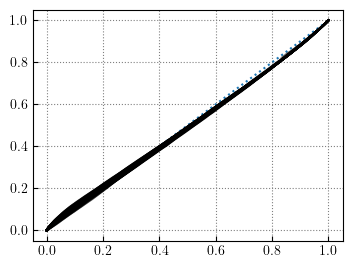

In [32]:
fig,ax = plt.subplots()

ax.plot(m_grid,np.quantile(cdf_ms_inj,0.05,axis=0),color=cnsbh,lw=1.5,label='Injection Reweighting')
ax.plot(m_grid,np.quantile(cdf_ms_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(m_grid,np.quantile(cdf_ms_nn,0.05,axis=0),color=cbbh,lw=1.5,label='Neural Network Emulator')
ax.plot(m_grid,np.quantile(cdf_ms_nn,0.95,axis=0),color=cbbh,lw=1.5)
#ax.set_yscale('log')
#ax.set_xlim(0,100)
#ax.set_ylim(1e-6,1)
ax.set_xlabel('$m_1$ $[M_\odot]$')
ax.set_ylabel('$p(m_1)$ $[M_\odot^{-1}]$')
ax.legend(loc='lower right')
plt.show()

fig,ax = plt.subplots()
ax.plot([0,1],[0,1],ls=':')
for c in np.arange(0.02,1.,0.02):
    ax.plot(np.quantile(cdf_ms_inj,c,axis=0),np.quantile(cdf_ms_nn,c,axis=0),color='black',alpha=0.5)
plt.show()

In [44]:
dz = np.diff(z_grid)[0]
cdf_R_inj = np.cumsum(R_zs_inj,axis=1)
cdf_R_inj /= cdf_R_inj[:,-1][:,np.newaxis]
cdf_R_nn = np.cumsum(R_zs_nn,axis=1)
cdf_R_nn /= cdf_R_nn[:,-1][:,np.newaxis]

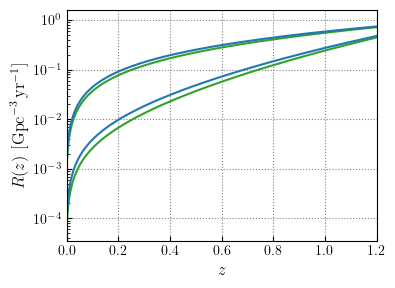

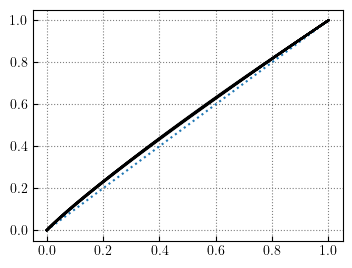

In [45]:
fig,ax = plt.subplots()
ax.plot(z_grid,np.quantile(cdf_R_inj,0.05,axis=0),color=cnsbh,lw=1.5)
ax.plot(z_grid,np.quantile(cdf_R_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(z_grid,np.quantile(cdf_R_nn,0.05,axis=0),color=cbbh,lw=1.5)
ax.plot(z_grid,np.quantile(cdf_R_nn,0.95,axis=0),color=cbbh,lw=1.5)
ax.set_yscale('log')
ax.set_xlim(0,1.2)
ax.set_xlabel('$z$')
ax.set_ylabel('$R(z)$ $[\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]$')
plt.show()

fig,ax = plt.subplots()
ax.plot([0,1],[0,1],ls=':')
for c in np.arange(0.04,1.,0.04):
    ax.plot(np.quantile(cdf_R_inj,c,axis=0),np.quantile(cdf_R_nn,c,axis=0),color='black',alpha=0.5)
plt.show()

In [46]:
dq = np.diff(q_grid)[0]
cdf_qs_inj = np.cumsum(p_qs_inj,axis=1)*dq
cdf_qs_nn = np.cumsum(p_qs_nn,axis=1)*dq

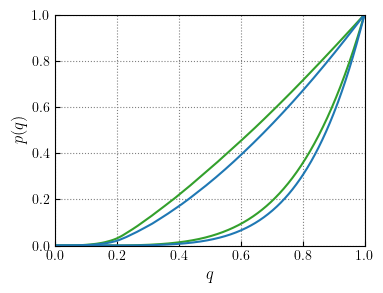

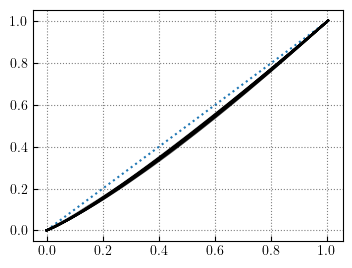

In [50]:
fig,ax = plt.subplots()
ax.plot(q_grid,np.quantile(cdf_qs_inj,0.05,axis=0),color=cnsbh,lw=1.5)
ax.plot(q_grid,np.quantile(cdf_qs_inj,0.95,axis=0),color=cnsbh,lw=1.5)
ax.plot(q_grid,np.quantile(cdf_qs_nn,0.05,axis=0),color=cbbh,lw=1.5)
ax.plot(q_grid,np.quantile(cdf_qs_nn,0.95,axis=0),color=cbbh,lw=1.5)
#ax.set_yscale('log')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel('$q$')
ax.set_ylabel('$p(q)$')
plt.show()

fig,ax = plt.subplots()
ax.plot([0,1],[0,1],ls=':')
for c in np.arange(0.04,1.,0.04):
    ax.plot(np.quantile(cdf_qs_inj,c,axis=0),np.quantile(cdf_qs_nn,c,axis=0),color='black',alpha=0.5)
plt.show()